PROJECT JARINGAN SYARAF TIRUAN

# 1. Load dan preprocessing data

In [247]:
pip install imbalanced-learn

In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE # Import SMOTE
from collections import Counter # Untuk melihat distribusi kelas

In [306]:
file_path = "indian_liver_patient.csv"
df = pd.read_csv(file_path)

In [307]:
# Cek missing values dan isi dengan median jika ada
print(df.isnull().sum())
for col in columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64


<ipython-input-307-ca6204837e06>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [308]:
# Cek missing values dan isi dengan median jika ada
print(df.isnull().sum())
# Pastikan 'columns' didefinisikan atau iterasi langsung pada df.columns
for col in df.columns: # Menggunakan df.columns agar lebih robust
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
Dataset                       0
dtype: int64


In [253]:
# Pisahkan fitur dan target
# DETEKSI "SAKIT/BERISIKO" SEBAGAI KELAS POSITIF (1) ***
# Dataset: 1 = Liver patient, 2 = Not liver patient
# Kita akan mendefinisikan: 1 = Liver patient (Sakit/Berisiko), 0 = Non-Liver patient (Sehat)
X = df.drop(columns=['Dataset']).values
y = (df['Dataset'].values == 1).astype(int).reshape(-1, 1) # Jika Dataset=1 (sakit), maka y=1. Jika Dataset=2 (sehat), maka y=0.

print(f"\nBentuk data X: {X.shape}")
print(f"Bentuk data y: {y.shape}")
print(f"Jumlah pasien sakit (y=1): {np.sum(y == 1)}")
print(f"Jumlah pasien sehat (y=0): {np.sum(y == 0)}")
print(f"Rasio kelas positif: {np.sum(y == 1) / len(y):.2f}")


Bentuk data X: (583, 10)
Bentuk data y: (583, 1)
Jumlah pasien sakit (y=1): 416
Jumlah pasien sehat (y=0): 167
Rasio kelas positif: 0.71


SPLIT DATA

In [255]:
print("\n--- SPLIT DATA ---")
def train_val_test_split(X, y, val_size=0.15, test_size=0.15, random_state=42):
    """
    Membagi data menjadi set pelatihan, validasi, dan pengujian.
    """
    np.random.seed(random_state)
    n = len(X)
    idx = np.random.permutation(n) # Mengacak indeks

    # Menghitung ukuran set
    test_split_idx = int(n * (1 - test_size))
    val_split_idx = int(test_split_idx * (1 - val_size / (1 - test_size))) # Proporsi val dari sisa data setelah test

    train_idx = idx[:val_split_idx]
    val_idx = idx[val_split_idx:test_split_idx]
    test_idx = idx[test_split_idx:]

    return X[train_idx], X[val_idx], X[test_idx], \
           y[train_idx], y[val_idx], y[test_idx]

# Menggunakan proporsi split yang sedikit berbeda untuk distribusi yang lebih merata
# Misalnya, 70% train, 15% val, 15% test
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

print(f"Bentuk X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Bentuk X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Bentuk X_test: {X_test.shape}, y_test: {y_test.shape}")

# --- Penerapan SMOTE di SINI ---
print("\n--- Menerapkan SMOTE pada data training ---")
print(f"Distribusi kelas y_train sebelum SMOTE: {Counter(y_train.flatten())}")

sm = SMOTE(random_state=42)
# SMOTE mengharapkan y dalam bentuk 1D, jadi kita gunakan y_train.flatten()
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train.flatten())

print(f"Distribusi kelas y_train setelah SMOTE: {Counter(y_train_resampled)}")

# Setelah SMOTE, y_train_resampled adalah 1D. Jika model Anda butuh 2D, reshape kembali.
y_train_resampled = y_train_resampled.reshape(-1, 1)

# --- Normalisasi fitur berdasarkan train set yang sudah di-resample ---
# PENTING: Mean dan Std harus dihitung dari X_train_resampled
mean = X_train_resampled.mean(axis=0)
std = X_train_resampled.std(axis=0)
std[std == 0] = 1 # Ganti 0 dengan 1 untuk menghindari ZeroDivisionError

X_train_normalized = (X_train_resampled - mean) / std
X_val_normalized = (X_val - mean) / std
X_test_normalized = (X_test - mean) / std

print(f"Bentuk X_train setelah SMOTE & Normalisasi: {X_train_normalized.shape}, y_train setelah SMOTE: {y_train_resampled.shape}")
print(f"Bentuk X_val setelah Normalisasi: {X_val_normalized.shape}, y_val: {y_val.shape}")
print(f"Bentuk X_test setelah Normalisasi: {X_test_normalized.shape}, y_test: {y_test.shape}")


--- SPLIT DATA ---
Bentuk X_train: (407, 10), y_train: (407, 1)
Bentuk X_val: (88, 10), y_val: (88, 1)
Bentuk X_test: (88, 10), y_test: (88, 1)

--- Menerapkan SMOTE pada data training ---
Distribusi kelas y_train sebelum SMOTE: Counter({np.int64(1): 289, np.int64(0): 118})
Distribusi kelas y_train setelah SMOTE: Counter({np.int64(0): 289, np.int64(1): 289})
Bentuk X_train setelah SMOTE & Normalisasi: (578, 10), y_train setelah SMOTE: (578, 1)
Bentuk X_val setelah Normalisasi: (88, 10), y_val: (88, 1)
Bentuk X_test setelah Normalisasi: (88, 10), y_test: (88, 1)


# 2. Neural Network dengan backpropagation

In [256]:
print("\n--- 2. Membangun Neural Network ---")
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.0):
        np.random.seed(42)
        self.dropout_rate = dropout_rate

        self.weights_input_hidden = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.bias_hidden = np.zeros((1, hidden_size))

        self.weights_hidden_output = np.random.randn(hidden_size, output_size) * np.sqrt(1.0 / hidden_size)
        self.bias_output = np.zeros((1, output_size))

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def feedforward(self, X, training=True):
        self.z1 = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        self.a1 = self.relu(self.z1)

        if training and self.dropout_rate > 0:
            self.mask = (np.random.rand(*self.a1.shape) > self.dropout_rate) / (1 - self.dropout_rate)
            self.a1 *= self.mask
        else:
            self.mask = np.ones_like(self.a1) # Should not scale during inference

        self.z2 = np.dot(self.a1, self.weights_hidden_output) + self.bias_output
        self.a2 = self.sigmoid(self.z2)
        return self.a2

    def compute_loss(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss

    def backward(self, X, y_true, y_pred, learning_rate):
        error_output = y_pred - y_true
        delta_output = error_output

        d_weights_hidden_output = np.dot(self.a1.T, delta_output)
        d_bias_output = np.sum(delta_output, axis=0, keepdims=True)

        error_hidden = np.dot(delta_output, self.weights_hidden_output.T)
        delta_hidden = error_hidden * self.relu_derivative(self.z1)

        if self.dropout_rate > 0:
            delta_hidden *= self.mask # Apply mask to delta_hidden in backward pass as well

        d_weights_input_hidden = np.dot(X.T, delta_hidden)
        d_bias_hidden = np.sum(delta_hidden, axis=0, keepdims=True)

        self.weights_hidden_output -= learning_rate * d_weights_hidden_output
        self.bias_output -= learning_rate * d_bias_output
        self.weights_input_hidden -= learning_rate * d_weights_input_hidden
        self.bias_hidden -= learning_rate * d_bias_hidden

    def train(self, X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size=32, patience=75):
        losses_train = []
        losses_val = []
        accuracies_train = []
        accuracies_val = []

        best_val_loss = float('inf')
        best_weights = None
        epochs_no_improve = 0

        n_samples = X_train.shape[0]

        print(f"\nMemulai pelatihan untuk {epochs} epoch...")
        for epoch in range(epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            for start in range(0, n_samples, batch_size):
                end = start + batch_size
                xb = X_shuffled[start:end]
                yb = y_shuffled[start:end]

                y_pred_batch = self.feedforward(xb, training=True)
                self.backward(xb, yb, y_pred_batch, learning_rate)

            # Evaluate on full training set
            y_pred_train = self.feedforward(X_train, training=False)
            loss_train = self.compute_loss(y_train, y_pred_train)
            losses_train.append(loss_train)
            preds_train = (y_pred_train > 0.5).astype(int)
            acc_train = np.mean(preds_train == y_train)
            accuracies_train.append(acc_train)

            # Evaluate on validation set
            y_pred_val = self.feedforward(X_val, training=False)
            loss_val = self.compute_loss(y_val, y_pred_val)
            losses_val.append(loss_val)
            preds_val = (y_pred_val > 0.5).astype(int)
            acc_val = np.mean(preds_val == y_val)
            accuracies_val.append(acc_val)

            # Early stopping logic
            if loss_val < best_val_loss:
                best_val_loss = loss_val
                best_weights = (self.weights_input_hidden.copy(),
                                self.weights_hidden_output.copy(),
                                self.bias_hidden.copy(),
                                self.bias_output.copy())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"\nEarly stopping di epoch {epoch+1} karena validasi loss tidak membaik selama {patience} epoch.")
                    # Restore best weights
                    (self.weights_input_hidden,
                     self.weights_hidden_output,
                     self.bias_hidden,
                     self.bias_output) = best_weights
                    break

            if epoch % 50 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch+1}/{epochs} - L_Train: {loss_train:.4f} | A_Train: {acc_train*100:.2f}% | L_Val: {loss_val:.4f} | A_Val: {acc_val*100:.2f}%")

        print("\nPelatihan selesai.")
        # Ensure best weights are loaded if training completed without early stopping
        if best_weights is not None and epochs_no_improve < patience:
             (self.weights_input_hidden,
              self.weights_hidden_output,
              self.bias_hidden,
              self.bias_output) = best_weights
        return losses_train, accuracies_train, losses_val, accuracies_val

    def predict(self, X, threshold=0.5):
        y_pred_proba = self.feedforward(X, training=False)
        return (y_pred_proba > threshold).astype(int)


--- 2. Membangun Neural Network ---


# 3. Inisialisasi dan training

In [287]:
input_size = X_train_normalized.shape[1] # Gunakan X_train_normalized
hidden_size = 8
output_size = 1

nn = NeuralNetwork(input_size, hidden_size, output_size, dropout_rate=0.9)

epochs = 1000
learning_rate = 0.0009
batch_size = 32
patience = 2500 # Coba patience yang lebih moderat dulu

losses_train, accuracies_train, losses_val, accuracies_val = nn.train(
    X_train_normalized, y_train_resampled, X_val_normalized, y_val, epochs, learning_rate, batch_size, patience) # Gunakan data SMOTE


Memulai pelatihan untuk 1000 epoch...
Epoch 1/1000 - L_Train: 0.6809 | A_Train: 57.79% | L_Val: 0.6444 | A_Val: 63.64%
Epoch 51/1000 - L_Train: 0.6466 | A_Train: 72.15% | L_Val: 0.6546 | A_Val: 60.23%
Epoch 101/1000 - L_Train: 0.6364 | A_Train: 73.18% | L_Val: 0.6429 | A_Val: 59.09%
Epoch 151/1000 - L_Train: 0.6248 | A_Train: 73.53% | L_Val: 0.6403 | A_Val: 59.09%
Epoch 201/1000 - L_Train: 0.6242 | A_Train: 74.74% | L_Val: 0.6312 | A_Val: 60.23%
Epoch 251/1000 - L_Train: 0.6177 | A_Train: 74.74% | L_Val: 0.6276 | A_Val: 60.23%
Epoch 301/1000 - L_Train: 0.6092 | A_Train: 75.43% | L_Val: 0.6154 | A_Val: 59.09%
Epoch 351/1000 - L_Train: 0.6098 | A_Train: 74.57% | L_Val: 0.6229 | A_Val: 61.36%
Epoch 401/1000 - L_Train: 0.6044 | A_Train: 74.22% | L_Val: 0.6215 | A_Val: 62.50%
Epoch 451/1000 - L_Train: 0.6041 | A_Train: 73.70% | L_Val: 0.6198 | A_Val: 61.36%
Epoch 501/1000 - L_Train: 0.6005 | A_Train: 74.05% | L_Val: 0.6127 | A_Val: 61.36%
Epoch 551/1000 - L_Train: 0.5927 | A_Train: 73.88% 

In [289]:
y_test_pred = nn.predict(X_test)
accuracy_test = np.mean(y_test_pred == y_test)
print(f"Akurasi pada data test: {accuracy_test*100:.2f}%")

Akurasi pada data test: 71.59%


In [290]:
print("\n--- 4. Evaluasi Model pada Data Test ---")

y_test_pred_proba = nn.feedforward(X_test, training=False)
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

def calculate_metrics(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1_score, {'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn}

test_accuracy, test_precision, test_recall, test_f1_score, confusion_matrix_counts = \
    calculate_metrics(y_test, y_test_pred)

print(f"\nHasil Evaluasi (Kelas Positif = 'Pasien Penyakit Hati / Berisiko'):")
print(f"Akurasi pada data test: {test_accuracy * 100:.2f}%")
print(f"Precision pada data test: {test_precision * 100:.2f}%")
print(f"Recall pada data test: {test_recall * 100:.2f}%")
print(f"F1-Score pada data test: {test_f1_score * 100:.2f}%")

print("\nConfusion Matrix (jumlah):")
print("--------------------------")
print(f"True Positive (TP): {confusion_matrix_counts['TP']}  (Benar memprediksi pasien sakit)")
print(f"False Negative (FN): {confusion_matrix_counts['FN']} (Gagal memprediksi pasien sakit)")
print(f"False Positive (FP): {confusion_matrix_counts['FP']} (Salah memprediksi orang sehat jadi sakit)")
print(f"True Negative (TN): {confusion_matrix_counts['TN']} (Benar memprediksi orang sehat)")
print("--------------------------")


--- 4. Evaluasi Model pada Data Test ---

Hasil Evaluasi (Kelas Positif = 'Pasien Penyakit Hati / Berisiko'):
Akurasi pada data test: 71.59%
Precision pada data test: 71.59%
Recall pada data test: 100.00%
F1-Score pada data test: 83.44%

Confusion Matrix (jumlah):
--------------------------
True Positive (TP): 63  (Benar memprediksi pasien sakit)
False Negative (FN): 0 (Gagal memprediksi pasien sakit)
False Positive (FP): 25 (Salah memprediksi orang sehat jadi sakit)
True Negative (TN): 0 (Benar memprediksi orang sehat)
--------------------------


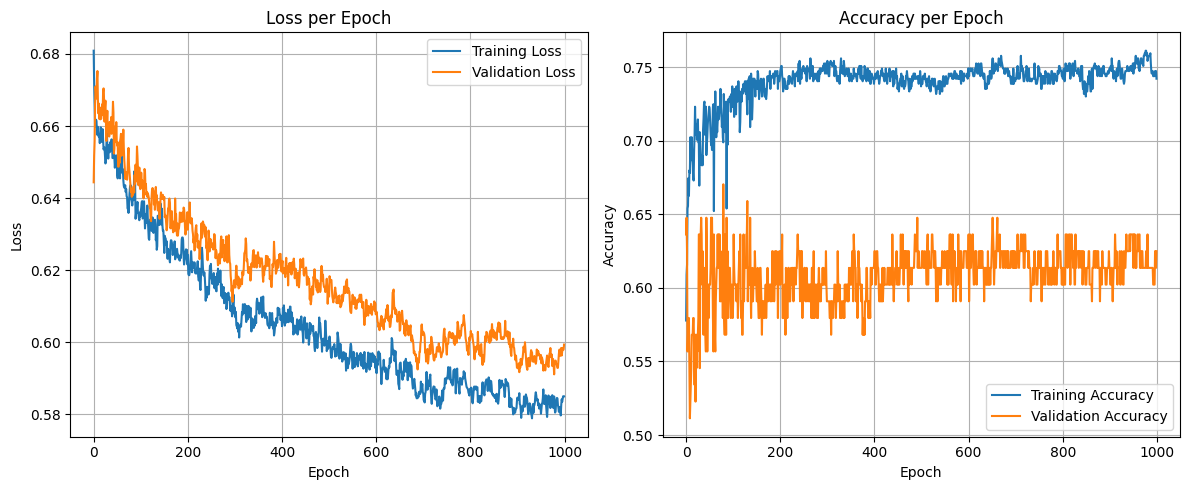

In [293]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses_train, label='Training Loss')
plt.plot(losses_val, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracies_train, label='Training Accuracy')
plt.plot(accuracies_val, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [294]:
# --- 6. Contoh Deteksi untuk Pasien Baru ---
print("\n--- 6. Contoh Deteksi untuk Pasien Baru ---")

# Data pasien baru (contoh dummy data)
# Tetap gunakan data mentah, normalisasi akan dilakukan setelah ini
data_pasien_baru_1 = np.array([[
    45,    # Age
    1,     # Gender (1 for Male, 0 for Female)
    1.2,   # Total_Bilirubin
    0.3,   # Direct_Bilirubin
    180,   # Alkphos_ALP
    45,    # Alamine_Aminotransferase_ALT
    50,    # Aspartate_Aminotransferase_AST
    7.0,   # Total_Protiens
    3.5,   # Albumin
    0.5    # Albumin_and_Globulin_Ratio
]])

data_pasien_baru_2 = np.array([[
    60,    # Age
    0,     # Gender (1 for Male, 0 for Female)
    5.5,   # Total_Bilirubin
    2.8,   # Direct_Bilirubin
    250,   # Alkphos_ALP
    150,   # Alamine_Aminotransferase_ALT
    200,   # Aspartate_Aminotransferase_AST
    6.0,   # Total_Protiens
    2.5,   # Albumin
    0.8    # Albumin_and_Globulin_Ratio
]])

data_pasien_baru_3 = np.array([[
    30,    # Age
    0,     # Gender (0 = Female)
    0.8,   # Total_Bilirubin
    0.2,   # Direct_Bilirubin
    100,   # Alkaline_Phosphotase
    20,    # Alamine_Aminotransferase
    25,    # Aspartate_Aminotransferase
    7.5,   # Total_Protiens
    4.0,   # Albumin
    1.1    # Albumin_and_Globulin_Ratio
]])

data_pasien_baru_4 = np.array([[
    55,    # Age
    1,     # Gender (1 = Male)
    4.5,   # Total_Bilirubin (tinggi)
    1.8,   # Direct_Bilirubin (tinggi)
    300,   # Alkaline_Phosphotase (tinggi)
    120,   # Alamine_Aminotransferase (tinggi)
    180,   # Aspartate_Aminotransferase (tinggi)
    6.0,   # Total_Protiens (agak rendah)
    2.8,   # Albumin (rendah)
    0.6    # Albumin_and_Globulin_Ratio (rendah)
]])

data_pasien_baru_5 = np.array([[
    40,    # Age
    0,     # Gender (0 = Female)
    1.5,   # Total_Bilirubin (agak tinggi)
    0.4,   # Direct_Bilirubin
    150,   # Alkaline_Phosphotase
    60,    # Alamine_Aminotransferase (agak tinggi)
    40,    # Aspartate_Aminotransferase
    6.8,   # Total_Protiens
    3.2,   # Albumin
    0.9    # Albumin_and_Globulin_Ratio
]])


--- 6. Contoh Deteksi untuk Pasien Baru ---


In [296]:
# Normalisasi data pasien baru menggunakan mean dan std dari TRAIN set (yang sudah di-resample)
data_pasien_baru_1_normalized = (data_pasien_baru_1 - mean) / std
data_pasien_baru_2_normalized = (data_pasien_baru_2 - mean) / std
data_pasien_baru_3_normalized = (data_pasien_baru_3 - mean) / std
data_pasien_baru_4_normalized = (data_pasien_baru_4 - mean) / std
data_pasien_baru_5_normalized = (data_pasien_baru_5 - mean) / std

In [313]:
print("\n--- Deteksi Pasien 1 ---")
probabilitas_1 = nn.feedforward(data_pasien_baru_1_normalized, training=False)
# Coba threshold 0.5 dan juga 0.6 atau 0.7 untuk perbandingan
prediksi_binary_1_06 = nn.predict(data_pasien_baru_1_normalized, threshold=0.6)

print(f"Probabilitas model (pasien hati): {probabilitas_1[0][0]:.4f}")
if prediksi_binary_1_06[0][0] == 1:
    print(f"Prediksi (Threshold 0.6): Pasien kemungkinan memiliki penyakit hati.")
else:
    print(f"Prediksi (Threshold 0.6): Pasien kemungkinan tidak memiliki penyakit hati.")


--- Deteksi Pasien 1 ---
Probabilitas model (pasien hati): 0.6891
Prediksi (Threshold 0.6): Pasien kemungkinan memiliki penyakit hati.


In [312]:
# --- Deteksi Pasien 2 ---
print("\n--- Deteksi Pasien 2 ---")
probabilitas_2 = nn.feedforward(data_pasien_baru_2_normalized, training=False)
prediksi_binary_2_05 = nn.predict(data_pasien_baru_2_normalized, threshold=0.5)

print(f"Probabilitas model (pasien hati): {probabilitas_2[0][0]:.4f}")
if prediksi_binary_2_05[0][0] == 1:
    print(f"Prediksi (Threshold 0.5): Pasien kemungkinan memiliki penyakit hati.")
else:
    print(f"Prediksi (Threshold 0.5): Pasien kemungkinan tidak memiliki penyakit hati.")


--- Deteksi Pasien 2 ---
Probabilitas model (pasien hati): 0.7899
Prediksi (Threshold 0.5): Pasien kemungkinan memiliki penyakit hati.


In [311]:
# --- Deteksi Pasien 3 ---
print("\n--- Deteksi Pasien 3 ---")
probabilitas_3 = nn.feedforward(data_pasien_baru_3_normalized, training=False)
prediksi_binary_3_05 = nn.predict(data_pasien_baru_3_normalized, threshold=0.5)

print(f"Probabilitas model (pasien hati): {probabilitas_3[0][0]:.4f}")
if prediksi_binary_3_05[0][0] == 1:
    print(f"Prediksi (Threshold 0.5): Pasien kemungkinan memiliki penyakit hati.")
else:
    print(f"Prediksi (Threshold 0.5): Pasien kemungkinan tidak memiliki penyakit hati.")


--- Deteksi Pasien 3 ---
Probabilitas model (pasien hati): 0.4223
Prediksi (Threshold 0.5): Pasien kemungkinan tidak memiliki penyakit hati.


In [310]:
# --- Deteksi Pasien 4 ---
print("\n--- Deteksi Pasien 4 ---")
probabilitas_4 = nn.feedforward(data_pasien_baru_4_normalized, training=False)
prediksi_binary_4_06 = nn.predict(data_pasien_baru_4_normalized, threshold=0.6)

print(f"Probabilitas model (pasien hati): {probabilitas_4[0][0]:.4f}")
if prediksi_binary_4_06[0][0] == 1:
    print(f"Prediksi (Threshold 0.6): Pasien kemungkinan memiliki penyakit hati.")
else:
    print(f"Prediksi (Threshold 0.6): Pasien kemungkinan tidak memiliki penyakit hati.")


--- Deteksi Pasien 4 ---
Probabilitas model (pasien hati): 0.8221
Prediksi (Threshold 0.6): Pasien kemungkinan memiliki penyakit hati.


In [309]:
# --- Deteksi Pasien 5 ---
print("\n--- Deteksi Pasien 5 ---")
probabilitas_5 = nn.feedforward(data_pasien_baru_5_normalized, training=False)
prediksi_binary_5_06 = nn.predict(data_pasien_baru_5_normalized, threshold=0.6)

print(f"Probabilitas model (pasien hati): {probabilitas_5[0][0]:.4f}")
if prediksi_binary_5_06[0][0] == 1:
    print(f"Prediksi (Threshold 0.6): Pasien kemungkinan memiliki penyakit hati.")
else:
    print(f"Prediksi (Threshold 0.6): Pasien kemungkinan tidak memiliki penyakit hati.")


--- Deteksi Pasien 5 ---
Probabilitas model (pasien hati): 0.4751
Prediksi (Threshold 0.6): Pasien kemungkinan tidak memiliki penyakit hati.
